# Project Part 1
## Question 1
### Imports and Data Wrangling

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq

ois = pd.read_excel("./data/IR Data.xlsx", sheet_name = 'OIS', usecols = ["Tenor", "Product", "Rate"])
tenors = ois["Tenor"]

# Define a function to convert tenor strings to years
def tenor_to_years(tenor):
    if 'm' in tenor:
        return int(tenor.replace('m', '')) / 12
    elif 'y' in tenor:
        return int(tenor.replace('y', ''))
    else:
        return None

ois["years"] = [tenor_to_years(tenor) for tenor in tenors]
years = [i for i in np.arange(1.0,30)]
ois[['f', 'df']] = np.nan
ois = ois.merge(pd.DataFrame({"years": years}),
                   how='outer')
ois.head(7)

,Tenor,Product,Rate,years,f,df
0,6m,OIS,0.00250,0.5,NaN,NaN
1,1y,OIS,0.00300,1.0,NaN,NaN
2,2y,OIS,0.00325,2.0,NaN,NaN
3,3y,OIS,0.00335,3.0,NaN,NaN
4,4y,OIS,0.00350,4.0,NaN,NaN
5,5y,OIS,0.00360,5.0,NaN,NaN
6,NaN,NaN,NaN,6.0,NaN,NaN


### Solve for year 1 Discount Factor
Use the swap formula where we consider a par swap as the following:
$$
\sum_{i=1}^{n} D(0, T_i) \times \Delta_{i-1} \times L(T_{i-1}, T_i) = 1 - D(0, T_n) \\
\sum_{i=1}^{n} D(0, T_i) \times \Delta_{i-1} \times L(T_{i-1}, T_i) - (1 - D(0, T_n))= 0 \tag{1}
$$
Equation (1) can be a function of the unknown discount factor and can be used as objective function. After using Solver to find the root of equation (1), this root is the Discount Factor(df) for that year.

### get f for 0.5 year


In [31]:
f_0 = 360 * ((0.5*.0025+1)**(1/180)-1)
ois.at[0,'f'] = f_0

ois.head(2)

,Tenor,Product,Rate,years,f,df
0,6m,OIS,0.0025,0.5,0.002498,NaN
1,1y,OIS,0.0030,1.0,NaN,NaN


In [32]:
def payer_ois_swap_1y(f_1, f_0, ois_1y):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg 
    FOR FIRST YEAR ONLY
    paramters:
        f_0: zero rate 0 to .5 years
        f_1: zero rate .5 to 1 years
    """
    D_1 = 1/((1+f_0/360)**180 * (1+f_1/360)**180)

    fix_leg = D_1 * ois_1y
    flt_leg = D_1 * (1/D_1 - 1)

    return fix_leg - flt_leg
    
guess = 0.99

# Solve for zero rate from 0.5y to 1y
f_1 = fsolve(payer_ois_swap_1y, 
                         guess, 
                         args=(ois.at[0, 'f'],
                               ois.at[1, 'Rate']))[0]
ois.at[1, 'f'] = f_1
ois.at[1, 'df'] = 1/((1+f_0/360)**180 * (1+f_1/360)**180)
ois.head(2)

,Tenor,Product,Rate,years,f,df
0,6m,OIS,0.0025,0.5,0.002498,NaN
1,1y,OIS,0.0030,1.0,0.003493,0.997009


### Solve zero rates for remaining years

In [33]:
def D(t,df_ois, f_t):
    """
    Return discount factor
    FOR SECOND YEAR ONWARDS only
    parameters:
        t: maturity in years
        f: zero rate in annual terms for the latest year
    """
    D = 1
    D *= 1/((1+df_ois.at[0,'f'] /360)**180 * (1+df_ois.at[1,'f']/360)**180) #instantiate with 1y DF

    for i in range(2,int(t+1)):  # loop year 2 to year t
        f_i = ois.set_index('years')['f'].get(i, f_t)
        if pd.isna(f_i):        # assign the latest f_t if no f value in table
            f_i = f_t           # wrong since earlier periods with gaps will still take the latest value
        D *= 1/((1+f_i/360)**360)       # multiply each year's discount factor
        
    return D

def payer_ois_swap_2y(f_n, df_ois, T):
    """
    Return PV of payer swap i.e. PV of fixed leg minus PV of floating leg 
    FOR SECOND YEAR ONWARDS
    paramters:
        f_n: zero rate from n-1 to n years
        df_ois: DataFrame of OIS and f values
        T: maturity of swap
    """
    if T <2:
        return "only for 2 year onwards"
    fix_leg = 0
    flt_leg = 0
    cumsum_df = 0
    # compute for 1y df 
    D1 = 1/((1+df_ois.at[0,'f'] /360)**180 * (1+df_ois.at[1,'f']/360)**180)
    flt_leg += D1 * (1/D1-1)
    cumsum_df += D1

    for i in range(2,int(T+1)):
        f_i = ois.set_index('years')['f'].get(i, f_n)
        if pd.isna(f_i):        # if there is no f value then assign the latest f
            f_i = f_n
        Di = D(i,ois,f_i)
        # for year 2 onwards add the df to the counters
        flt_leg +=  Di * ((1+f_i/360)**360-1)
        cumsum_df += Di
    
    fix_leg = cumsum_df * df_ois.loc[df_ois['years']==i,'Rate'].values[0] 

    return flt_leg-fix_leg

# D(2.0,ois,.00350275), payer_ois_swap_2y(.0025, ois, 2)

In [34]:
guess = 0.0035
iter_idx = ois.loc[~ois.Tenor.isna()].index[2:].values      # list of tenors with OIS data

for i in iter_idx:
    T = ois.loc[i,'years']
    f_i = fsolve(payer_ois_swap_2y, 
                            guess, 
                            args=(ois,
                                    T))[0]
    ois.at[i, 'f'] = f_i            # update df
    ois['f'] = ois['f'].bfill()     # assume zero rate is constant over through the gap period

    guess = f_i

# fill 0.5 year
ois.at[0,'df'] = 1/(1+f_0/360)**180

ois.head(10)

,Tenor,Product,Rate,years,f,df
0,6m,OIS,0.00250,0.5,0.002498,0.998752
1,1y,OIS,0.00300,1.0,0.003493,0.997009
2,2y,OIS,0.00325,2.0,0.003495,NaN
3,3y,OIS,0.00335,3.0,0.003545,NaN
4,4y,OIS,0.00350,4.0,0.003946,NaN
5,5y,OIS,0.00360,5.0,0.003996,NaN
6,NaN,NaN,NaN,6.0,0.005003,NaN
7,7y,OIS,0.00400,7.0,0.005003,NaN
8,NaN,NaN,NaN,8.0,0.005680,NaN
9,NaN,NaN,NaN,9.0,0.005680,NaN


### Interpolate semi-annual DF and cumsum

In [35]:
ois.loc[:1, 'period_df'] = ois[:2].apply(lambda row: 1 / ((1 + row['f'] / 360) ** (180)), axis=1)
ois.loc[2:, 'period_df'] = ois[2:].apply(lambda row: 1 / ((1 + row['f'] / 360) ** (360)), axis=1)
ois['df'] = ois['period_df'].cumprod()
ois.drop(columns=['period_df'], inplace=True)

ois.head(20)

,Tenor,Product,Rate,years,f,df
0,6m,OIS,0.00250,0.5,0.002498,0.998752
1,1y,OIS,0.00300,1.0,0.003493,0.997009
2,2y,OIS,0.00325,2.0,0.003495,0.993531
3,3y,OIS,0.00335,3.0,0.003545,0.990015
4,4y,OIS,0.00350,4.0,0.003946,0.986117
5,5y,OIS,0.00360,5.0,0.003996,0.982184
6,NaN,NaN,NaN,6.0,0.005003,0.977283
7,7y,OIS,0.00400,7.0,0.005003,0.972406
8,NaN,NaN,NaN,8.0,0.005680,0.966898
9,NaN,NaN,NaN,9.0,0.005680,0.961422


### Plot OIS DF curve

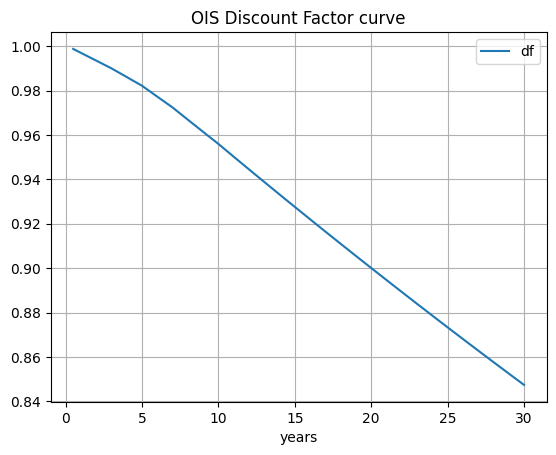

In [36]:
ois.plot(x='years',y='df')
plt.title("OIS Discount Factor curve")
plt.grid(True)
plt.show()

## Question 2
### Imports and Data Wrangling

In [37]:
irs = pd.read_excel("./data/IR Data.xlsx", sheet_name = 'IRS', usecols = ["Tenor", "Product", "Rate"])
# Convert each tenor to years
irs["years"] = [tenor_to_years(tenor) for tenor in tenors]

irs = irs.merge(ois[['years','f']],on='years',how='outer')
irs.rename(columns={"df": "ois_df"}, inplace=True)
years = [i for i in np.arange(1,30,.5)]
irs = irs.merge(pd.DataFrame({"years": years}), how='outer')
irs["f"] = irs.f.bfill()
irs['period_df'] = 1/(1+irs['f']/360)**180
irs['ois_df'] = irs['period_df'].cumprod()
irs.drop(columns=['period_df'],inplace=True)
irs["libor_df"] = np.nan

irs.head(3)

,Tenor,Product,Rate,years,f,ois_df,libor_df
0,6m,LIBOR,0.025,0.5,0.002498,0.998752,NaN
1,1y,IRS,0.028,1.0,0.003493,0.997009,NaN
2,NaN,NaN,NaN,1.5,0.003495,0.995268,NaN


### solve for IRS swap with OIS discount factors

$$
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS = \sum^N_{i=1} D_o(0,T_i) \times L(T_{i-1}, T_i) \\
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=1} D_o(0,T_i) \times L(T_{i-1}, T_i)  = 0 \\ 
\sum^N_{i=1} D_o(0,T_i) \times \Delta_i \times IRS - \sum^N_{i=1} D_o(0,T_i) 
\times \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]  = 0 \\ 
$$

where $L(T_{i-1}, T_i) = \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]$

First obtain LIBOR discount factor

In [38]:
def payer_irs_swap(df, i, irs):
    """
    Return value of payer swap
    parameters:
        df: df for year at maturity
        i : row index of irs for maturity of swap
        irs: DataFrame of irs including ois discount factors (ois_df) and libor discount factors (libor_df)
    """
    irs1 = irs.copy()
    irs1.at[i,'libor_df'] = df
    irs1[['years','libor_df']] = irs1[['years','libor_df']].interpolate(method='linear')    # assume linear interpolation for gap years

    # fix_leg = cumsum_ois_df * 0.5 * IRS
    cumsum_ois_df = irs1['ois_df'].iloc[:i+1].sum()     # PVBP
    irs_rate = irs1.at[i,'Rate']                        # par swap rate
    fix_leg = cumsum_ois_df * 0.5 * irs_rate

    # float leg = D_o(j) * (D(j-1)-D(j))/D(j) for j in range i
    float_leg = irs1.at[0,'ois_df'] * (1-irs1.at[0,'libor_df']) / irs1.at[0,'libor_df']     # instantiate with 0.5 year cashflow
    for j in range(1,i+1):            # loop remaining years and sum up discounted cashflow
        float_leg += irs1.at[j,'ois_df'] * (irs1.at[j-1,'libor_df']-irs1.at[j,'libor_df']) \
                                            / irs1.at[j,'libor_df']

    return float_leg - fix_leg

irs.at[0,'libor_df'] = 1/(1+irs.at[0,'Rate']/2)     # assign first libor df
idx_irs = irs[irs['Product'] == "IRS"].index[1:]        # collate list of indices with IRS
guess = .99

# iterate through years
for i in idx_irs:       # skip first index since already computed
        x = fsolve(payer_irs_swap,
                    guess,
                    args=(i,irs))[0]
        irs.at[i, 'libor_df'] = x
        guess = x                       # IMPORTANT to update guess, there is multiple roots
irs['libor_df'] = irs['libor_df'].interpolate(method='linear')

irs.head()

,Tenor,Product,Rate,years,f,ois_df,libor_df
0,6m,LIBOR,0.025,0.5,0.002498,0.998752,0.987654
1,1y,IRS,0.028,1.0,0.003493,0.997009,0.972496
2,NaN,NaN,NaN,1.5,0.003495,0.995268,0.957338
3,2y,IRS,0.030,2.0,0.003495,0.993531,0.942179
4,NaN,NaN,NaN,2.5,0.003545,0.991771,0.926330


### Plot LIBOR DF curve

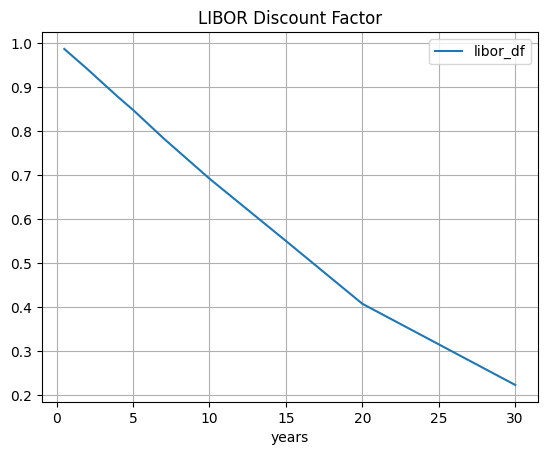

In [39]:
irs.plot(x='years',y='libor_df')
plt.title("LIBOR Discount Factor")
plt.grid(True)
plt.show()

## Question 3
Solving for forward IRS will be similar interpolating LIBOR, however the starting points will not be at 0 

**LIBOR forward swaps**
$$
\sum^N_{i=s+1} D_o(0,T_i) \times \Delta_i \times IRS_{forward} - \sum^N_{i=s+1} D_o(0,T_i) 
\times \left[\frac{D(0,T_{i-1})-D(0,T_{i})}{D(0,T_{i})}\right]  = 0 \\ 
$$
**OIS forward swaps**
$$\begin{aligned}
OIS_{forward} &= 
            \frac{D_o(0,T_{s})-D_o(0,T_{N})}
                    {\Delta_i  \sum^N_{i=s+1}D_o(0,T_{i})} \\
            &= 
            \frac{D_o(0,T_{s})-D_o(0,T_{N})}
                    {\Delta_i  \left[ \sum^s_{i=0}D_o(0,T_{i}) - \sum^N_{i=0}D_o(0,T_{i}) \right]} \\
\end{aligned}$$

where $s$ is the start of the rate agreement and N is maturity.

Create a new df for annual OIS cumsum df

In [40]:
def payer_irs_fwd_swap(fwd_swap_rate, start=1, tenor=1, irs=irs):
    """
    Return value of forward payer swap starting from year 1 ahead
    Parameters:
        fwd_swap_rate:
        start: in years, 
        i: tenor in years, 
        irs: Dataframe of IRS rates, libor/OIS df
    """
    # fix_leg = cumsum_ois_df * 0.5 * IRS
    # for forward starting, deduct the starting period DF
    cumsum_ois_df = irs.loc[irs['years'] <= start+tenor, 'ois_df'].sum() \
                        - irs.loc[irs['years'] <= start, 'ois_df'].sum()
    fix_leg = cumsum_ois_df * 0.5 * fwd_swap_rate

    # float leg = D_o(j) * (D(j-1)-D(j))/D(j) for j in range i
    float_leg = 0
    for j in range(int(start*2),int((start+tenor)*2)):
        float_leg += irs.at[j,'ois_df'] * (irs.at[j-1,'libor_df']-irs.at[j,'libor_df']) \
                                            / irs.at[j,'libor_df']

    return fix_leg - float_leg

# payer_irs_fwd_swap(.032007, 1, 1, irs)

In [41]:
# instantiate Forward Swap Rate table
fsr = pd.DataFrame({'start' : [1]*5 + [5]*5 + [10]*5,
                          'tenor' : [1,2,3,5,10]*3, 
                          'f_irs': [np.nan]*15, 
                          'f_ois': [np.nan]*15})

# iterate through table and get FRA
for idx, row in fsr.iterrows():
    start = row['start']
    tenor = row['tenor']
    ois_day_frac = 1    # ois is annual payments
    L = 1

    # compute forward Libor
    fsr.at[idx, 'f_irs'] = fsolve(payer_irs_fwd_swap,
                                      guess,
                                      args=(start,
                                            tenor,
                                            irs))
    
    # compute forward OIS
    num = ois.loc[ois.years==start]['df'].values[0] - ois.loc[ois.years==start+tenor]['df'].values[0]
    den = ois_day_frac * (ois.loc[ois.years<=start+tenor]['df'].sum() - ois.loc[ois.years<=start]['df'].sum())
    fsr.at[idx, 'f_ois'] = num/den

fsr

,start,tenor,f_irs,f_ois
0,1,1,0.031922,0.003501
1,1,2,0.033217,0.003526
2,1,3,0.033982,0.003668
3,1,5,0.035238,0.004002
4,1,10,0.038419,0.004804
5,5,1,0.039274,0.005015
6,5,2,0.040075,0.005015
7,5,3,0.040072,0.005241
8,5,5,0.041093,0.005421
9,5,10,0.043634,0.005727


---

#### Compute values for next parts

In [42]:
# for Part 2 Q3
df_irs_fwd = pd.DataFrame([[2, 10], [8, 10]], columns=["Expiry", "Tenor"])
df_irs_fwd['f_irs'] = np.nan
df_irs_fwd['f_ois'] = np.nan

for idx, start, tenor, _, _ in df_irs_fwd.itertuples():
    # compute forward Libor
    par_rate = fsolve(payer_irs_fwd_swap,
                        guess,
                        args=(start,
                            tenor,
                            irs))
    df_irs_fwd.at[idx, 'f_irs'] = par_rate
    # compute forward OIS
    num = ois.loc[ois.years==start]['df'].values[0] - ois.loc[ois.years==start+tenor]['df'].values[0]
    den = ois_day_frac * (ois.loc[ois.years<=start+tenor]['df'].sum() - ois.loc[ois.years<=start]['df'].sum())
    df_irs_fwd.at[idx, 'f_ois'] = num/den
    
df_irs_fwd

,Expiry,Tenor,f_irs,f_ois
0,2,10,0.039634,0.005058
1,8,10,0.048711,0.005972


In [43]:
fsr.to_csv('./data/fsr.csv', index=False)
ois.to_csv('./data/ois.csv', index=False)
irs.to_csv('./data/irs.csv', index=False)
df_irs_fwd.to_csv('./data/irs_fwd.csv', index=False)

In [51]:
ois

,Tenor,Product,Rate,years,f,df
0,6m,OIS,0.00250,0.5,0.002498,0.998752
1,1y,OIS,0.00300,1.0,0.003493,0.997009
2,2y,OIS,0.00325,2.0,0.003495,0.993531
3,3y,OIS,0.00335,3.0,0.003545,0.990015
4,4y,OIS,0.00350,4.0,0.003946,0.986117
5,5y,OIS,0.00360,5.0,0.003996,0.982184
6,NaN,NaN,NaN,6.0,0.005003,0.977283
7,7y,OIS,0.00400,7.0,0.005003,0.972406
8,NaN,NaN,NaN,8.0,0.005680,0.966898
9,NaN,NaN,NaN,9.0,0.005680,0.961422
